In [1]:
'''
AlexNet architecture
+---------+-----------------+-------------------------------+------------------+
| Layer   | Type            | Configuration                 | Output Size      |
+---------+-----------------+-------------------------------+------------------+
| Input   | Image           | 227 x 227 x 3 (RGB)           | 227 x 227 x 3    |
| Conv 1  | Convolution     | 96 filters (11x11), Stride 4  | 55 x 55 x 96     |
| Pool 1  | Max Pooling     | 3x3 window, Stride 2          | 27 x 27 x 96     |
| Conv 2  | Convolution     | 256 filters (5x5), Padding 2  | 27 x 27 x 256    |
| Pool 2  | Max Pooling     | 3x3 window, Stride 2          | 13 x 13 x 256    |
| Conv 3  | Convolution     | 384 filters (3x3), Padding 1  | 13 x 13 x 384    |
| Conv 4  | Convolution     | 384 filters (3x3), Padding 1  | 13 x 13 x 384    |
| Conv 5  | Convolution     | 256 filters (3x3), Padding 1  | 13 x 13 x 256    |
| Pool 3  | Max Pooling     | 3x3 window, Stride 2          | 6 x 6 x 256      |
| FC 6    | Fully Connected | 4096 Neurons + Dropout        | 4096             |
| FC 7    | Fully Connected | 4096 Neurons + Dropout        | 4096             |
| FC 8    | Fully Connected | 1000 Neurons (Softmax)        | 1000             |
+---------+-----------------+-------------------------------+------------------+

After the Conv3 and Conv4, we don't add MaxPool or AvgPool to avoid shrinking too quickly,
losing critical spatial information before the network could extract high-level features.
'''
print()

In [2]:
#########################
## Importing libraries ##
#########################

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
#########################
## Dataset downloading ##
#########################
'''
Import Animals-10 dataset with more than 23k images from HuggingFace
Run this first in terminal: pip install datasets
'''

from datasets import load_dataset

# Load dataset from huggingface
animals_10 = load_dataset(path="Rapidata/Animals-10", split="train")

# Print the structure
print(animals_10)
# Dataset({
#     features: ['image', 'label'],
#     num_rows: 23554
# })

Dataset({
    features: ['image', 'label'],
    num_rows: 23554
})


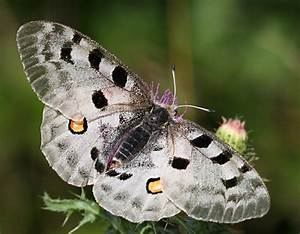

In [5]:
# Show an image
animals_10['image'][1000]

In [7]:
print(animals_10[1000]['image'])
# <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7A2EBA2F0410>

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x234 at 0x72614CF1D8E0>


In [8]:
#########################
## Image Preprocessing ##
#########################

IMG_SIZE = 224

#--------
## Initial preprocessing
#--------

preprocess = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ]
)

inputs_temp = []

for record in tqdm(iterable=animals_10, desc="Preprocessing Images"):
    image = record['image']
    label = record['label']
    
    # Convert from grayscale to RGB (3-colour channels)
    if image.mode == "L":
        image = image.convert("RGB")
        
    # preprocessing
    input_tensor = preprocess(image)
    label_tensor = torch.tensor(label)
    
    # append to inputs_temp
    inputs_temp.append([input_tensor, torch.tensor(label)])
    
#----
## Calculate mean and std after inital preprocessing
#----

import numpy as np

np.random.seed(0)
idx = np.random.randint(0, len(inputs_temp), 10000)

tensor_placeholder = torch.concat([inputs_temp[i][0] for i in idx], axis=1)
print(tensor_placeholder.shape)
# torch.Size([3, 2240000, 224])

mean_all = torch.mean(tensor_placeholder, dim=(1, 2))
std_all = torch.std(tensor_placeholder, dim=(1, 2))

print(mean_all) # tensor([0.5210, 0.5053, 0.4184])
print(std_all)  # tensor([0.2645, 0.2610, 0.2787])

#----
## Re-normalize with calculated mean and std
#----

preprocess = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_all, std=std_all)
    ]
)

inputs_final = []

for record in tqdm(iterable=animals_10, desc="Preprocessing Images"):
    image = record['image']
    label = record['label']
    
    # Convert from grayscale to RGB (3-colour channels)
    if image.mode == "L":
        image = image.convert("RGB")
        
    # preprocessing
    input_tensor = preprocess(image)
    label_tensor = torch.tensor(label)
    
    # append to inputs_temp
    inputs_final.append([input_tensor, torch.tensor(label)])
    
del inputs_temp

Preprocessing Images:   0%|          | 0/23554 [00:00<?, ?it/s]

torch.Size([3, 2240000, 224])
tensor([0.5210, 0.5053, 0.4184])
tensor([0.2645, 0.2610, 0.2787])


Preprocessing Images:   0%|          | 0/23554 [00:00<?, ?it/s]

In [12]:
#######################
## Dataset splitting ##
#######################

#-----
## Takes images and labels out
#-----

images, labels = zip(*inputs_final)
'''
Work like this
images = [item[0] for item in data_list]
labels = [item[1] for item in data_list]
'''

images = torch.stack(images, dim=0) # X
labels = torch.stack(labels, dim=0) # y

print(images.shape) # torch.Size([23554, 3, 224, 224])
print(labels.shape) # torch.Size([23554])

#-----
## Train - Val - Test split
#-----

train_len = int(0.7 * len(images)) # MUST be INTEGER
val_len = int(0.15 * len(images))
test_len = len(images) - (train_len + val_len)

print(train_len, val_len, test_len)
# 16487 3533 3534

from torch.utils.data import DataLoader, TensorDataset, random_split

full_dataset = TensorDataset(images, labels)

train_split, val_split, test_split = random_split(dataset=full_dataset, lengths=[train_len, val_len, test_len])

#-----
## Train - Val - Test loader
#-----

BATCH_SIZE = 32

train_set = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True) # shuffle=True to reshuffle the data after every epoch
val_set = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=False)
test_set = DataLoader(test_split, batch_size=BATCH_SIZE, shuffle=False)

torch.Size([23554, 3, 224, 224])
torch.Size([23554])
16487 3533 3534


In [15]:
###################################
## Building AlexNet-inspired CNN ##
###################################
'''
At each block, the images are downsampled by the max-pooling layer. 

Contrary, the number of channels from one layer to another increased from 3 to 64, to 192, ... to 256. 
=> As we learned before, deeper layers have larger receptive fields and generally detect more specific and complex features, 
such as ears, eyes, or even human faces and dogs. The chosen filter (or kernel) size is either or even human faces and dogs.

How will it increase from 3 channels to 64 channels?
    => The layer creates 64 separate filters (kernels), where each filter processes all 3 input channels together
    => Each has shape: 4x4x3 (kernel_size=4, and depth=3 to match input channels)
    => Filter 1 (4x4x3) convolves with RGB input → produces feature map 1
       Filter 2 (4x4x3) convolves with RGB input → produces feature map 2
       ...
       Filter 64 (4x4x3) convolves with RGB input → produces feature map 64
    => Stack all 64 feature maps together = 64 output channels

The kernel_size refers to the height and width of the sliding window (also called filter)
The chosen filter (or kernel) size is either 3 or 4. Example, kernel_size=4 => sliding window is 4x4
This is a common choice - having a smaller filter allows the network to better generalize. 

Padding is the process of adding a "border" of extra pixels (usually zeros) around the edges of your input image before the convolution operation begins.
Padding helps avoid shrinkage and loss of edge information.
=> Here, padding is 1 pixel on each layer.
'''

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            # Block 1: conv -> relu -> max_pool
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Block 2: conv -> relu -> max_pool
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Block 3: conv -> relu
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # Block 4: conv -> relu
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
                       
            # Block 5: conv -> relu -> max_pool
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.fc = nn.Sequential(           
            # Convolutional and pooling layers output 4D tensors (Batch, Channels, Height, Width)
            # However, Fully Connected layers expect 2D tensors (Batch, Features)
            # => must FLATTEN the 4D tensor into a 2D tensor
            nn.Flatten(),
                        
            # Block 6: drop_out -> fc_linear -> relu
            nn.Dropout(p=0.5),
            nn.LazyLinear(512), # Automatically figures out input size
            nn.ReLU(),
            
            # Block 7: drop_out -> fc_linear -> relu
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            
            
            # Block 8: fc_linear -> final logits (output)
            nn.Linear(256, num_classes)
        )
        
    def forward(self, X):
        out = self.cnn(X)
        out = self.fc(out)
        return out
'''
Block 1:
# Conv2d (kernel=4, padding=1): 32 + 2(1) - 4 + 1 = 31 → (batch, 64, 31, 31)
# MaxPool (kernel=3, stride=2): (31 - 3)/2 + 1 = 15 → (batch, 64, 15, 15)

Block 2:
# Conv2d (kernel=4, padding=1): 15 + 2(1) - 4 + 1 = 14 → (batch, 192, 14, 14)
# MaxPool (kernel=3, stride=2): (14 - 3)/2 + 1 = 6 → (batch, 192, 6, 6)

Block 3:
# Conv2d (kernel=3, padding=1): 6 + 2(1) - 3 + 1 = 6 → (batch, 384, 6, 6)

Block 4:
# Conv2d (kernel=3, padding=1): 6 + 2(1) - 3 + 1 = 6 → (batch, 256, 6, 6)

Block 5:
# Conv2d (kernel=3, padding=1): 6 + 2(1) - 3 + 1 = 6 → (batch, 256, 6, 6)
# MaxPool (kernel=3, stride=2): (6 - 3)/2 + 1 = 2 → (batch, 256, 2, 2) ✓


After Flatten:
256 channels x 2 height x 2 width = 1024 features
Final shape: (batch, 1024) → ready for nn.Linear(1024, 512)

#################

Formula for Conv2d output size:
    output_size = (input_size - kernel_size + 2*padding) / stride + 1
'''
print()

In [26]:
##########################
## model initialization ##
##########################

num_classes = len(animals_10.features['label'].names)
print(num_classes) # 10

torch.manual_seed(42)
model = AlexNet(num_classes=num_classes).to(device)

# Initialize lazy layers
with torch.no_grad():
    dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)  # Match your input size
    _ = model(dummy)

##################################
## Loss - Optimizer - Scheduler ##
##################################

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=6, factor=0.5)

10


In [27]:
################################
## Training - Validating loop ##
################################

epochs = 60

train_loss_list, val_loss_list = [], []

for epoch in tqdm(iterable=range(1, epochs+1), desc="Training"):
    # --- TRAINING ---
    _ = model.train() # Turn on training mode, enable gradient tracking
    for _, (images, labels) in enumerate(train_set):
        # moves values to device
        images = images.to(device)
        labels = labels.to(device)
        
        # (Standard training steps: forward, loss, zero_grad, backward, step)
        preds = model(images).squeeze()
        loss = loss_fn(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # --- VALIDATION (Every epoch) ---
    _ = model.eval() # 1. Set model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0
    with torch.inference_mode(): # 2. Turn off gradient tracking to save memory      
        for _, (images, labels) in enumerate(val_set): # 3. Iterate through val_set
            # moves values to device
            images = images.to(device)
            labels = labels.to(device)
            
            # calculate predictions
            val_preds = model(images).squeeze()
            
            # Accumulate loss to get an average for the whole set
            val_loss += loss_fn(val_preds, labels).item()
            
            # Calculate accuracy
            total += labels.size(0)
            predicted = torch.argmax(val_preds, dim=1)
            correct += (predicted == labels).sum().item()
        
          
    
    avg_val_loss = val_loss / len(val_set)
    avg_val_acc = 100 * (correct / total)  
    
    train_loss_list.append(loss.item())
    val_loss_list.append(avg_val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    
    scheduler.step(avg_val_loss)
    
    if (epoch % 10 == 0) or (epoch == 1):
        tqdm.write("+"*50)
        tqdm.write(f"Epoch: {epoch}")
        tqdm.write(f"Train loss: {loss:.4f}")
        tqdm.write(f"Validation loss: {avg_val_loss:.4f}")
        tqdm.write(f"Validation accuracy: {avg_val_acc:.2f}%")
        tqdm.write(f"Current LR: {current_lr}")

Training:   0%|          | 0/60 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 1
Train loss: 2.2879
Validation loss: 1.5544
Validation accuracy: 46.19%
Current LR: 0.0001
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 10
Train loss: 0.7113
Validation loss: 0.9376
Validation accuracy: 73.34%
Current LR: 0.0001
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 20
Train loss: 0.0061
Validation loss: 1.5476
Validation accuracy: 75.06%
Current LR: 5e-05
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 30
Train loss: 0.0001
Validation loss: 1.7573
Validation accuracy: 76.56%
Current LR: 1.25e-05
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 40
Train loss: 0.0000
Validation loss: 1.8981
Validation accuracy: 76.90%
Current LR: 6.25e-06
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 50
Train loss: 0.0009
Validation loss: 1.9485
Validation accuracy: 76.99%
Current LR: 1.5625e-06
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 60
Train loss: 0.0000
Validati

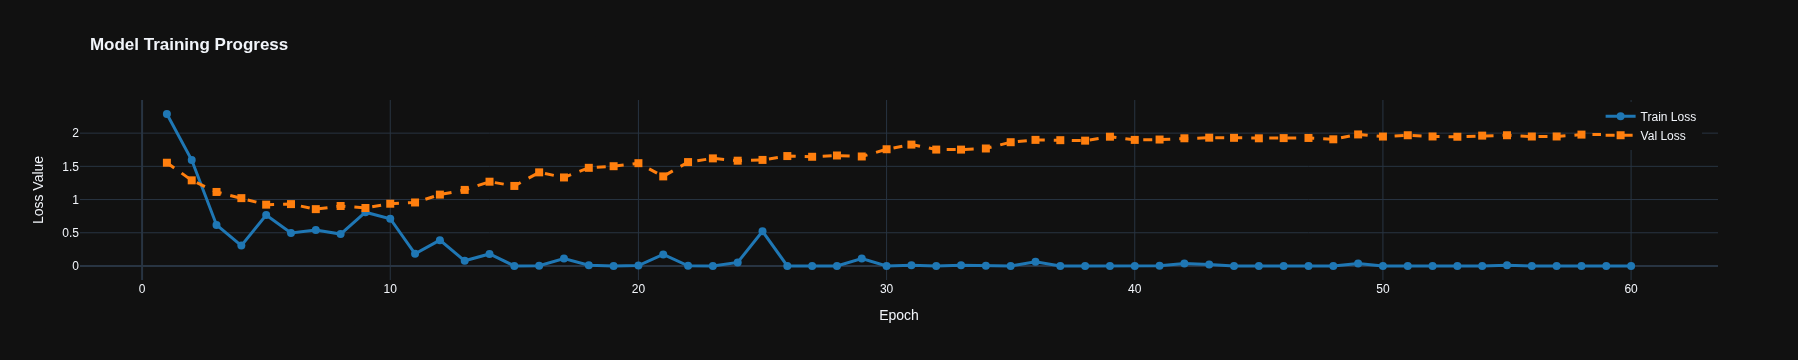

In [28]:
#######################################
## Drawing Train and Val loss curves ##
#######################################

def plot_train_val_loss_curves(epochs, train_loss_list, val_loss_list):
    import plotly.graph_objects as pgo
    import numpy as np
    
    # 1. Define the X-axis (epochs)
    epoch_axis = np.arange(1, epochs + 1, 1)

    fig = pgo.Figure()

    # 2. Add Training Loss
    fig.add_trace(pgo.Scatter(
        x=epoch_axis,
        y=train_loss_list,
        mode='lines+markers',
        name='Train Loss',
        line=dict(color='#1f77b4', width=3),
        marker=dict(size=8)
    ))

    # 3. Add Validation Loss
    fig.add_trace(pgo.Scatter(
        x=epoch_axis,
        y=val_loss_list,
        mode='lines+markers',
        name='Val Loss',
        line=dict(color='#ff7f0e', width=3, dash='dash'),
        marker=dict(size=8, symbol='square')
    ))

    # 4. Layout & Styling
    fig.update_layout(
        title='<b>Model Training Progress</b>',
        xaxis_title='Epoch',
        yaxis_title='Loss Value',
        template='plotly_dark', # Clean dark background
        hovermode='x unified',   # Shows both values on hover
        legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99)
    )

    fig.show()
    
plot_train_val_loss_curves(epochs, train_loss_list, val_loss_list)

Classification report
               precision    recall  f1-score   support

   Butterfly       0.86      0.81      0.84       243
         Cat       0.60      0.33      0.42       186
     Chicken       0.86      0.83      0.84       462
         Cow       0.66      0.59      0.62       284
         Dog       0.68      0.82      0.74       722
    Elephant       0.71      0.65      0.68       150
       Horse       0.74      0.72      0.73       390
       Sheep       0.63      0.64      0.64       202
      Spider       0.83      0.92      0.88       624
    Squirrel       0.73      0.60      0.66       271

    accuracy                           0.75      3534
   macro avg       0.73      0.69      0.71      3534
weighted avg       0.75      0.75      0.74      3534



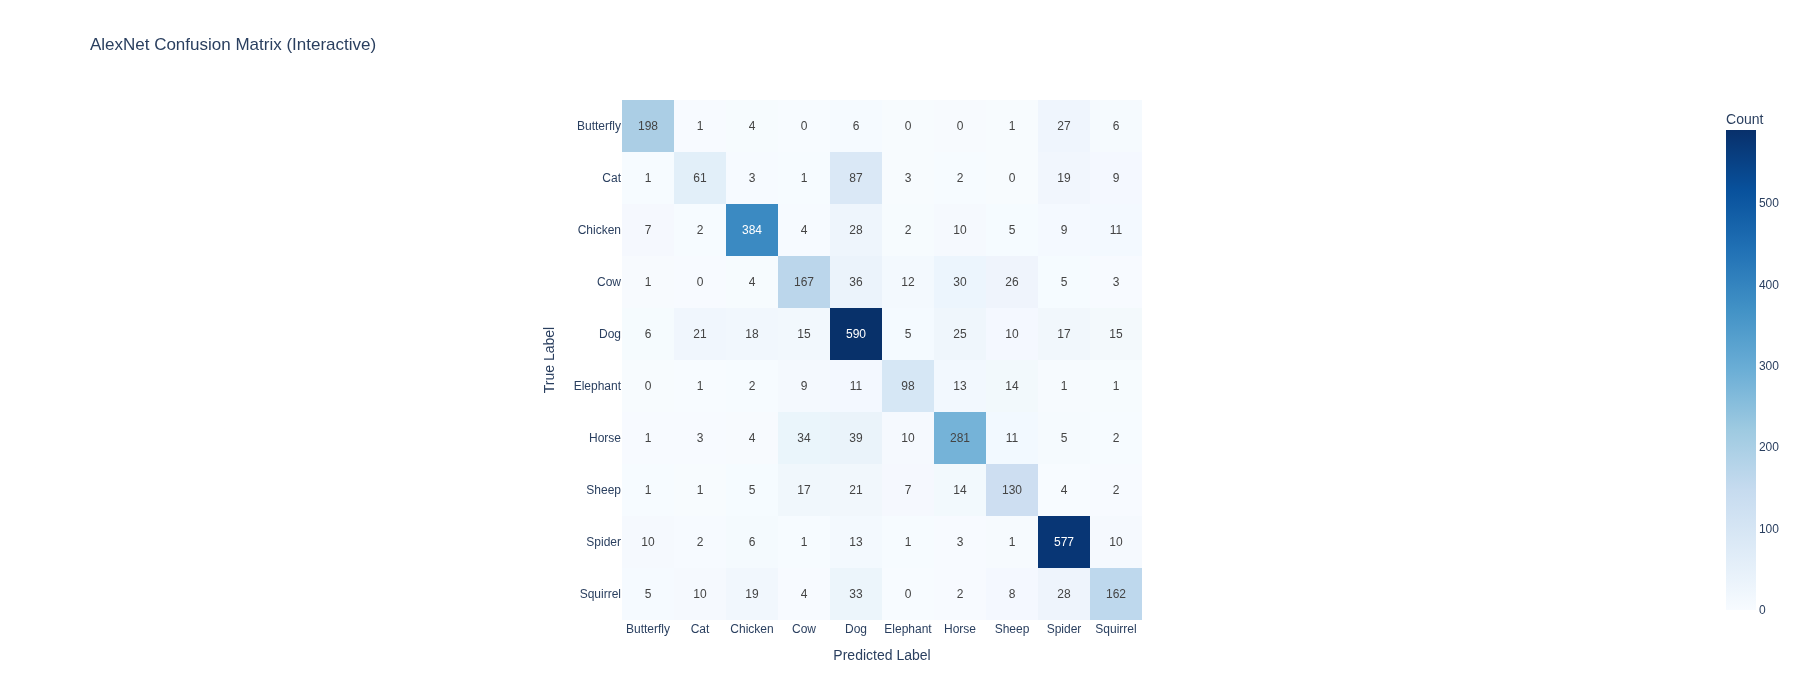

In [29]:
#############
## Testing ##
#############

class_names = animals_10.features['label'].names

from sklearn.metrics import confusion_matrix, classification_report

# 1. Put model in eval mode
_ = model.eval()
all_preds = []
all_labels = []

with torch.inference_mode():
    for images, labels in test_set:
        images = images.to(device)
        
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 2. Generate the raw confusion matrix array
cm = confusion_matrix(all_labels, all_preds)

# 3. Print classification report
print('Classification report\n', classification_report(y_true=all_labels, y_pred=all_preds, target_names=class_names))
# Classification report
#                precision    recall  f1-score   support

#    Butterfly       0.86      0.81      0.84       243
#          Cat       0.60      0.33      0.42       186
#      Chicken       0.86      0.83      0.84       462
#          Cow       0.66      0.59      0.62       284
#          Dog       0.68      0.82      0.74       722
#     Elephant       0.71      0.65      0.68       150
#        Horse       0.74      0.72      0.73       390
#        Sheep       0.63      0.64      0.64       202
#       Spider       0.83      0.92      0.88       624
#     Squirrel       0.73      0.60      0.66       271

#     accuracy                           0.75      3534
#    macro avg       0.73      0.69      0.71      3534
# weighted avg       0.75      0.75      0.74      3534
        
import plotly.express as px

fig = px.imshow(
    cm,
    text_auto=True,               # Shows the numbers inside the squares
    labels=dict(x="Predicted", y="Actual", color="Count"),
    x=class_names,
    y=class_names,
    color_continuous_scale='Blues',
    title='AlexNet Confusion Matrix (Interactive)'
)

fig.update_layout(
    xaxis_title='Predicted Label',
    yaxis_title='True Label',
    width=700,
    height=700
)

fig.show()

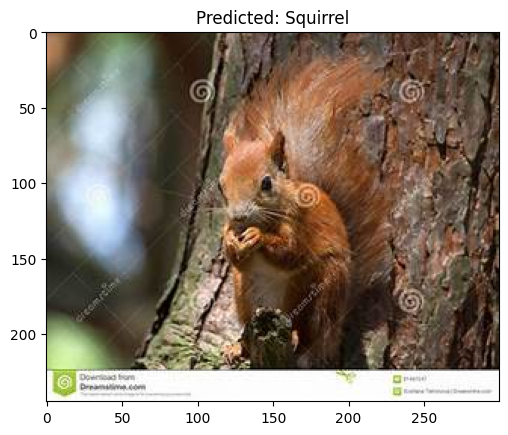

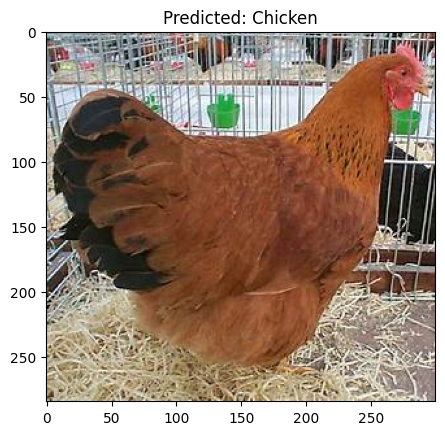

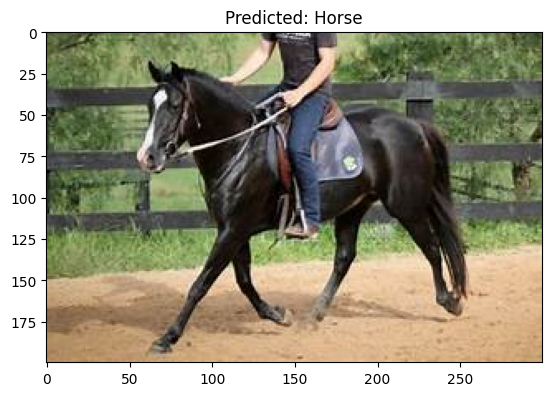

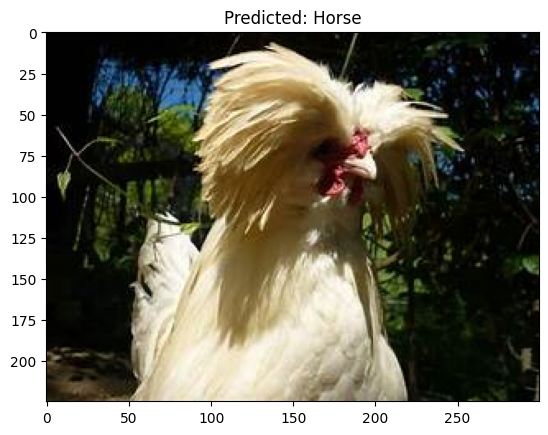

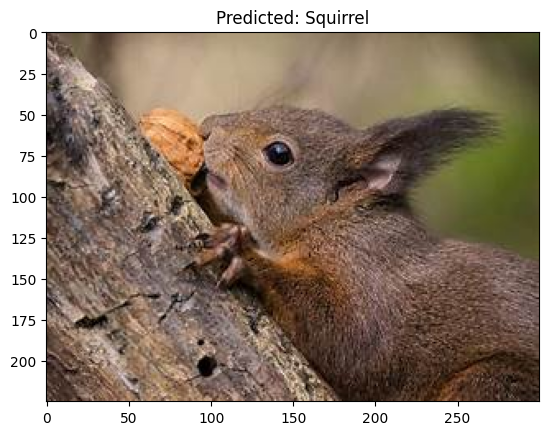

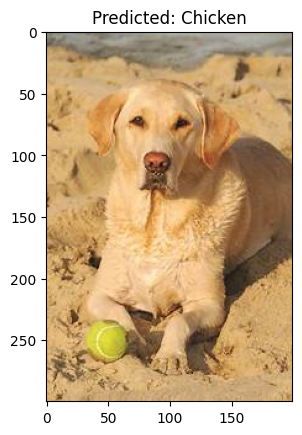

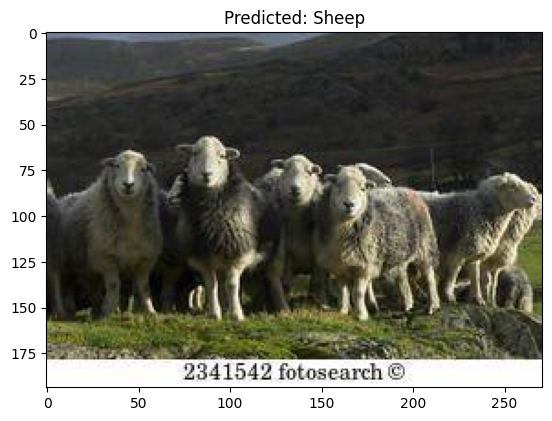

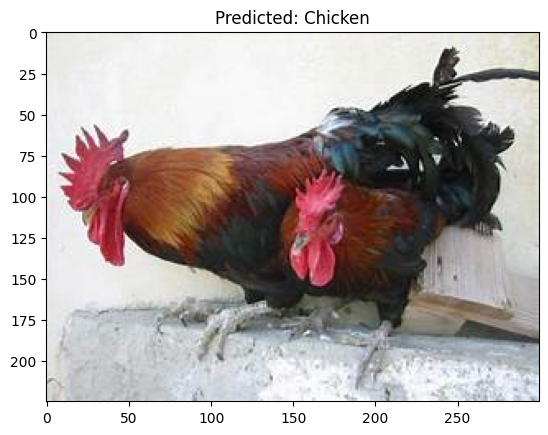

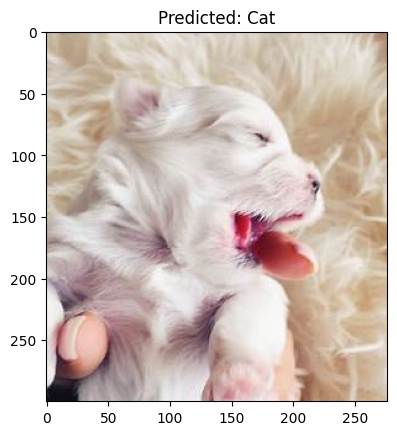

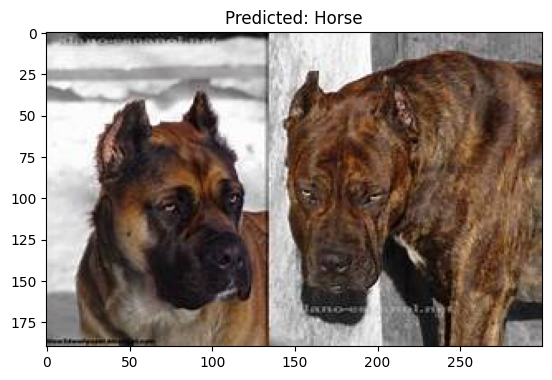

In [32]:
#----------
## Visualize some random predicted images (test_set)
#----------

np.random.seed(43)
idx_random = np.random.randint(0, test_len+1, 10)

import matplotlib.pyplot as plt

for i in idx_random:
    print("="*50)
    idx_original = test_split.indices[i]
    image = animals_10['image'][idx_original]
    predict_class = animals_10.features['label'].names[all_preds[i]]
    plt.title(f"Predicted: {predict_class}")
    plt.imshow(image)
    plt.show()

In [18]:
########################
## Saving whole model ##
########################

# import os
# os.chdir('../')
# os.getcwd() # '/home/longdpt/Documents/Long_AISDL/DeepLearning_PyTorch'

from pathlib import Path

MODEL_PATH = Path("04_CNN").joinpath("save")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# PyTorch model can be saved in .pth or .pt format
PARAMS_NAME = "AlexNet_model.pth"

# Save the model (use model.state_dict() to save only the parameters)
torch.save(obj=model, f=MODEL_PATH.joinpath(PARAMS_NAME))